In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.errors import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
from include.beauti_print import *
from include.create_basketball_player_data import *
from include.basketball_players_hypothesis_testing_functions import *
pd.set_option('expand_frame_repr', False)
from sklearn import preprocessing
from scipy.stats import shapiro, f_oneway, kruskal, zscore

<div class="alert alert-block alert-success">
To keep the notebook clean and make it more readable, I have kept all the user defined functions inside the include folder.
</div>

<div style=" line-height: 90px;height: 90px;text-align: center; font-size: 60px; background-color: NavajoWhite ; color: black;height:100%">
Intro
</div>

ou can find a plethora of viewpoints online, with some asserting that taller basketball players excel more, while others contend that height is not a pivotal factor. Hence, we will proceed with hypothesis testing.
<br><br>
<b>Our null hypothesis (H0) states:</b> Height has no significant effect on basketball performance.<br>
<b>Our alternative hypothesis (H1) posits:</b> Height does have a significant effect on basketball 

<div style=" line-height: 90px;height: 90px;text-align: center; font-size: 60px; background-color: NavajoWhite ; color: black;height:100%">
Dataset building
</div>

I have collected the required data for the project from two website.

1. __[number fire](https://www.numberfire.com)__: A website that provides details such as team ranking, players ranking, players statistics etc.
1. __[the sports db](https://www.thesportsdb.com/free_sports_api)__: Which provides api for datils about verious sports, players, team etc (I am using this api to fetch basic details like players age, height, weight etc)

#### How to create the dataset ?

1. You can follow the below three steps.
1. You can download the dataset from __[here](https://github.com/manab36/Data-Analysis/blob/bd0414d026b2720f96bf34bf7d981c692279a542/dataset/basketball_players.csv)__.
1. You can modify(the output location if needed) and run the `include/create_basketball_player_data.py` script.

Incase of option 2 or 3 follow from dataset exploring


#

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Step I. webscraping from <a href="https://www.numberfire.com">numberfire</a>
</div>

<p>

From the numberfire website we will scape the data using __[BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/)__. <br>
1. To Get all players name and rankings participating in NBA.
1. To get all teams name and rankings participating in NBA.
</p>

In [ ]:
players_details_df= get_players_details_numberfire()
players_details_df

In [ ]:
players_details_df.columns = [i+'_'+v for i,v in players_details_df.columns.tolist()]
players_details_df

In [ ]:
players_details_df.info()

In [ ]:
team_details_df= get_team_details_numberfire()
team_details_df

In [ ]:
team_details_df.info()

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Step II. api call <a href="https://www.thesportsdb.com/free_sports_api">thesportsdb</a>
</div>
<p>

To get the general details about the players from the list we got from the numberfire website we will call api using __[request](https://requests.readthedocs.io/en/latest/)__. <br>
The data here is noisy (some columns have different types of values like for some player the api will provide the height in cm, in feet, maximum having both etc) and have too many columns, so we also need to clean the data a bit before making the final dataset
</p>

In [ ]:
players_details_2_df= get_players_details_by_list_name(players_details_df['player_name'])
players_details_2_df

In [ ]:
players_details_2_df.info()

In [ ]:
clean_player_details_df= clean_player_details_data(players_details_2_df)
clean_player_details_df

In [ ]:
clean_player_details_df.info()

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Step III. merge all the details in one table
</div>

1. Merge the table with the general data of the player, with the teams details
1. Merge the previously merged data with players ranking data
1. Dump the final table to a csv file


In [ ]:
merge_df= clean_player_details_df.merge(team_details_df, on='team', how= 'left', indicator=True)
merge_df= merge_df[merge_df["_merge"]== "both"].drop(columns= "_merge")
merge_df

In [ ]:
merge_df_2= merge_df.merge(players_details_df, on='player_name', how= 'left', indicator=True)
final_data= merge_df_2[merge_df_2["_merge"]== "both"].drop(columns= "_merge")
final_data

In [ ]:
final_data.info()

In [ ]:
final_data.to_csv(R"dataset\basketball_players.csv", index= False)

<div style=" line-height: 90px;height: 90px;text-align: center; font-size: 60px; background-color: NavajoWhite ; color: black;height:100%">
Dataset Description and Preprocessing
</div>

#

##### efficiency matrices in NBA and what they stands for:

<table style= "font-family: arial, sans-serif; border-collapse: collapse; width: 100%;">
  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">short</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">full form</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">description</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">nerd</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">numberFire Efficiency Rating Derivative</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">d system of evaluating every player in the NBA based on various offensive and defensive efficiency metrics. NERD rating for players shows production in efficiency.escription</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">nf eff</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">nF Efficiency</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">metric measures a player's raw efficiency. More specifically, it is an estimate for the point differential that a league-average team would have with that player as one of the five starters. <br>It combines both offensive and defensive production on a per possession basis.</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">fantansy</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">fantansy</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">The NBA's standard fantasy points scoring system dictates: Points = 1.0 fantasy point. Rebounds = 1.2 fantasy points. Assists = 1.5 fantasy points. Steals = 3.0 fantasy points.</th>
  </tr>

</table>

##### statistics matrices in NBA and what they stands for:

<table style= "font-family: arial, sans-serif; border-collapse: collapse; width: 100%;">
  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">short</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">full form</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">description</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">mpg</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">Minutes Played Per Game</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">The average number of minutes a player has played per game. Formula: Minutes / Games</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">ppg</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">Points Per Game</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">is a statistical measure of a player's scoring per game. It is simply calculated by taking total points, and dividing it by total games over his over a season, career, or a stretch.</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">rpg</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">Rebounds Per Game</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">he average number of total rebounds per game. Formula: (RBO + RBD) / Games</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">apg</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">Assist Per Game</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">An assist is attributed to a player who passes the ball to a teammate in a way that leads directly to a score by field goal, meaning that they were "assisting" in the basket. An assist is also credited when a basket is awarded due to defensive goaltending.</th>
  </tr>

</table>

In [2]:
data= pd.read_csv(R"dataset\basketball_players.csv")
data.head(4)

,player_name,team,sport,birth_date,birth_location,active_status,gender,height_in_cm,weight_in_lb,team_rank,conference,division,player_rank,efficiency_nerd,efficiency_nf_eff,efficiency_fantasy,statistics_mpg,statistics_ppg,statistics_rpg,statistics_apg
0,Shai Gilgeous-Alexander,Oklahoma City Thunder,Basketball,1998-07-12,"Toronto, Ontario",True,M,198.0,180.0,3,Western Conference,Northwest,2,22.9,7.3,12.91,34.4,30.3,5.5,6.3
1,Giannis Antetokounmpo,Milwaukee Bucks,Basketball,1994-12-06,"Athens, Greece",True,M,211.0,242.0,7,Eastern Conference,Central,3,19.9,6.2,6.36,35.2,30.7,11.5,6.5
2,Anthony Davis,Los Angeles Lakers,Basketball,1993-03-11,"Chicago, Illinois",True,M,208.0,253.0,17,Western Conference,Pacific,5,14.3,4.3,13.71,35.8,24.8,12.8,3.5
3,Jayson Tatum,Boston Celtics,Basketball,1998-03-03,"St. Louis, Missouri, USA",True,M,203.0,209.0,1,Eastern Conference,Atlantic,6,13.5,4.1,7.50,35.8,27.0,8.2,4.9


<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Only keeping currently active Basketball Male players in the dataset
</div>

`At the I was building data dataset I didn't encounter any records which needed to be dropped based on above condition`

In [3]:
data= clean_non_active_players(data)
data

**********************************************************************************************************************************
Cleaning Non active players, Not male players and Non basketball players
**********************************************************************************************************************************


,player_name,team,birth_date,birth_location,height_in_cm,weight_in_lb,team_rank,conference,division,player_rank,efficiency_nerd,efficiency_nf_eff,efficiency_fantasy,statistics_mpg,statistics_ppg,statistics_rpg,statistics_apg
0,Shai Gilgeous-Alexander,Oklahoma City Thunder,1998-07-12,"Toronto, Ontario",198.0,180.0,3,Western Conference,Northwest,2,22.9,7.3,12.91,34.4,30.3,5.5,6.3
1,Giannis Antetokounmpo,Milwaukee Bucks,1994-12-06,"Athens, Greece",211.0,242.0,7,Eastern Conference,Central,3,19.9,6.2,6.36,35.2,30.7,11.5,6.5
2,Anthony Davis,Los Angeles Lakers,1993-03-11,"Chicago, Illinois",208.0,253.0,17,Western Conference,Pacific,5,14.3,4.3,13.71,35.8,24.8,12.8,3.5
3,Jayson Tatum,Boston Celtics,1998-03-03,"St. Louis, Missouri, USA",203.0,209.0,1,Eastern Conference,Atlantic,6,13.5,4.1,7.50,35.8,27.0,8.2,4.9
4,Jalen Brunson,New York Knicks,1996-08-31,"New Brunswick, New Jersey",185.0,190.0,8,Eastern Conference,Atlantic,7,13.2,4.0,4.57,35.2,28.0,3.6,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,Royce O'Neale,Phoenix Suns,1993-06-05,"Killeen, Texas",193.0,226.0,10,Western Conference,Pacific,493,-2.8,-1.2,-0.52,24.7,7.7,4.8,2.8
404,Keldon Johnson,San Antonio Spurs,1999-11-11,"Chesterfield, Virginia",196.0,220.0,26,Western Conference,Southwest,493,-2.8,-1.1,-0.22,29.6,15.8,5.5,2.9
405,Santi Aldama,Memphis Grizzlies,2001-01-10,NaN,213.0,224.0,25,Western Conference,Southwest,493,-2.8,-1.4,-2.51,26.5,10.7,5.8,2.3
406,Gordon Hayward,Oklahoma City Thunder,1990-03-23,"Indianapolis, Indiana",201.0,225.0,3,Western Conference,Northwest,498,-2.9,-1.9,-4.71,24.5,9.7,3.5,3.2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         408 non-null    object 
 1   team                408 non-null    object 
 2   birth_date          408 non-null    object 
 3   birth_location      406 non-null    object 
 4   height_in_cm        408 non-null    float64
 5   weight_in_lb        407 non-null    float64
 6   team_rank           408 non-null    int64  
 7   conference          408 non-null    object 
 8   division            408 non-null    object 
 9   player_rank         408 non-null    int64  
 10  efficiency_nerd     408 non-null    float64
 11  efficiency_nf_eff   408 non-null    float64
 12  efficiency_fantasy  408 non-null    float64
 13  statistics_mpg      408 non-null    float64
 14  statistics_ppg      408 non-null    float64
 15  statistics_rpg      408 non-null    float64
 16  statisti

<div style=" line-height: 90px;height: 90px;text-align: center; font-size: 60px; background-color: NavajoWhite ; color: black;height: 100%">
Hypothesis testing I
</div>

#

<h2>based on <b>nerd</b> and four different <b>age group</b></h2>



<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Colomuns selections, Grouping, Cleaning Outliers for Hypothesis testing
</div>

### distribution 
1. Devide the players into different Height groups
1. plot kde with hue
1. Shapiro test for each group if necessary: Shapiro-Wilk test is a test of normality, it determines whether the given sample comes from the normal distribution or not. Shapiro-Wilk’s test or Shapiro test is a normality test in frequentist statistics. The null hypothesis of Shapiro’s test is that the population is distributed normally.
    - Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
    - Ha(Rejected): Sample is not from the normal distributions.

In [5]:
data.columns

Index(['player_name', 'team', 'birth_date', 'birth_location', 'height_in_cm',
       'weight_in_lb', 'team_rank', 'conference', 'division', 'player_rank',
       'efficiency_nerd', 'efficiency_nf_eff', 'efficiency_fantasy',
       'statistics_mpg', 'statistics_ppg', 'statistics_rpg', 'statistics_apg'],
      dtype='object')

In [6]:
htest_nerd_df= data[["height_in_cm", "efficiency_nerd"]] # data[["height_in_cm", "player_rank", "efficiency_nerd"]]
print(htest_nerd_df.info())
print(htest_nerd_df["height_in_cm"].min(), htest_nerd_df["height_in_cm"].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   height_in_cm     408 non-null    float64
 1   efficiency_nerd  408 non-null    float64
dtypes: float64(2)
memory usage: 6.5 KB
None
173.0 224.00000000000003


### distribution 
we are going to test two different grouping
1. group_type1 (pandas.cut): simply based on range, That is in n number of equal bins
1. group_type2 (pandas.qcut): The number of elements in each bin will be roughly the same, but this will come at the cost of differently sized interval widths.

In [7]:
htest_nerd_df['group_type1'] = pd.cut(htest_nerd_df['height_in_cm'], bins=4, labels=['short', 'mid', 'tall', 'taller'])
htest_nerd_df['group_type2'] = pd.qcut(htest_nerd_df['height_in_cm'], q=4, labels=['short', 'mid', 'tall', 'taller'])
htest_nerd_df

,height_in_cm,efficiency_nerd,group_type1,group_type2
0,198.0,22.9,mid,mid
1,211.0,19.9,tall,taller
2,208.0,14.3,tall,taller
3,203.0,13.5,tall,tall
4,185.0,13.2,short,short
...,...,...,...,...
403,193.0,-2.8,mid,short
404,196.0,-2.8,mid,mid
405,213.0,-2.8,taller,taller
406,201.0,-2.9,tall,tall


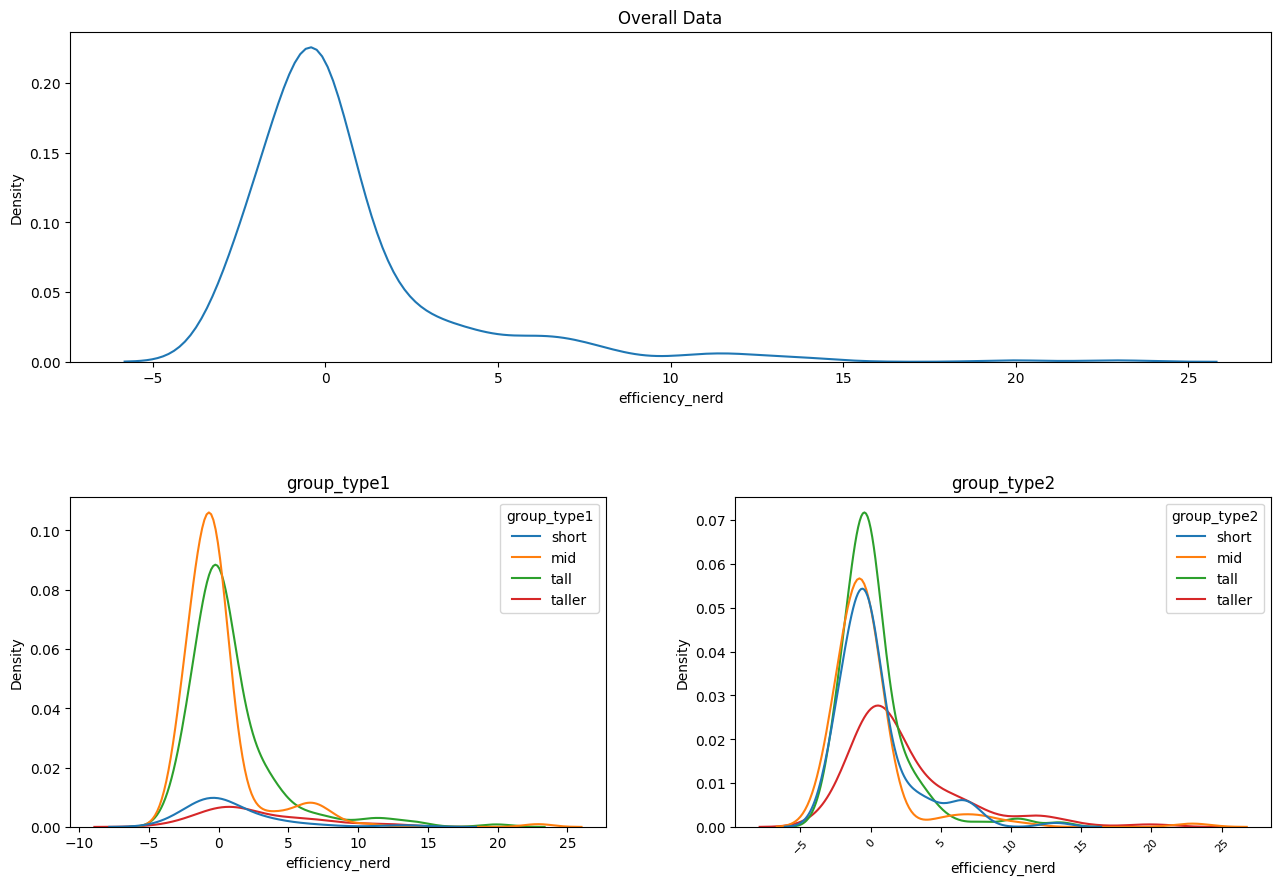

In [8]:
fig= plt.figure(figsize=(14,10))

plt.subplot(211).title.set_text('Overall Data')
sns.kdeplot(data= htest_nerd_df, x= "efficiency_nerd")

plt.subplot(223).title.set_text('group_type1')
sns.kdeplot(data= htest_nerd_df, x= "efficiency_nerd", hue= "group_type1")
plt.subplot(224).title.set_text('group_type2')
sns.kdeplot(data= htest_nerd_df, x= "efficiency_nerd", hue= "group_type2")

fig.tight_layout(pad=5.0)
plt.xticks(rotation=45,fontsize=8)
plt.show()

<div class="alert alert-block alert-info">
<b>Findings:</b> From above shapiro test and histograms the distribution is not normal distribution.<br>
</div>


So now we have 2 options:

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Option 1. Using ANOVA
</div>

- Step 1. Transform the right skewed data to normal distribution.
    - use Standardization if `mean is '0' and standard deviation is 1`
    - normalization
- Step 2. Peroform the ANOVA test.

##### We can add a positive number to efficiency_nerd, which wont effect the rating system but help us transforming our data to normal distribution

In [9]:
anova_df= htest_nerd_df.copy(deep=True)
anova_df["efficiency_nerd"]= htest_nerd_df["efficiency_nerd"]+ 3.0

#### 1. log

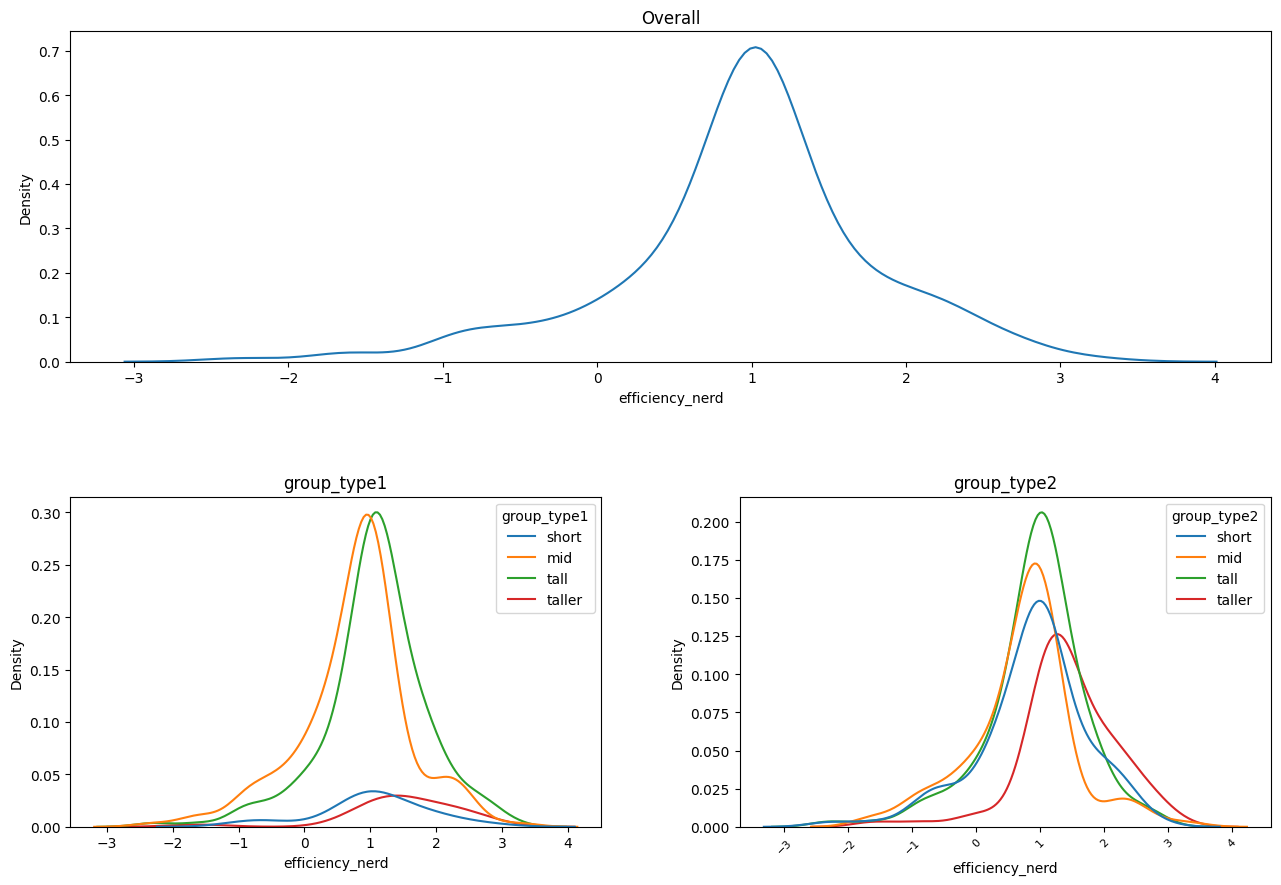

count    408.000000
mean       0.960714
std        0.839651
min       -2.302585
25%        0.680324
50%        1.029619
75%        1.321494
max        3.254243
Name: efficiency_nerd, dtype: float64
for over all: 
 ShapiroResult(statistic=0.9506591864176218, pvalue=1.9802749483524162e-10)
for group_type1:
 [ShapiroResult(statistic=0.9419922420761383, pvalue=1.2721644934366878e-06), ShapiroResult(statistic=0.9454440960780788, pvalue=2.227216013797867e-06), ShapiroResult(statistic=0.9334216828360452, pvalue=0.09351046955782866), ShapiroResult(statistic=0.831082311523505, pvalue=0.0009935070919736863)]
for group_type2:
 [ShapiroResult(statistic=0.9242523145240767, pvalue=1.9962077616234355e-05), ShapiroResult(statistic=0.9213989309660919, pvalue=0.0001107680231325784), ShapiroResult(statistic=0.9318884694569274, pvalue=9.266348039333011e-06), ShapiroResult(statistic=0.9446373258903021, pvalue=0.0003227962133533417)]


In [10]:
new_df= anova_df.copy(deep=True)

new_df["efficiency_nerd"]= np.log(new_df["efficiency_nerd"])

fig= plt.figure(figsize=(14,10))

plt.subplot(211).title.set_text('Overall')
sns.kdeplot(data= new_df, x= "efficiency_nerd")

plt.subplot(223).title.set_text('group_type1')
sns.kdeplot(data= new_df, x= "efficiency_nerd", hue= "group_type1")
plt.subplot(224).title.set_text('group_type2')
sns.kdeplot(data= new_df, x= "efficiency_nerd", hue= "group_type2")

fig.tight_layout(pad=5.0)
plt.xticks(rotation=45,fontsize=8)
plt.show()


print(new_df["efficiency_nerd"].describe())
print("for over all: \n", shapiro(new_df["efficiency_nerd"]))
print("for group_type1:\n", [shapiro(new_df[new_df["group_type1"]== i]["efficiency_nerd"]) for i in new_df["group_type1"].unique()])
print("for group_type2:\n", [shapiro(new_df[new_df["group_type2"]== i]["efficiency_nerd"]) for i in new_df["group_type2"].unique()])

del(new_df)

### 2. square root

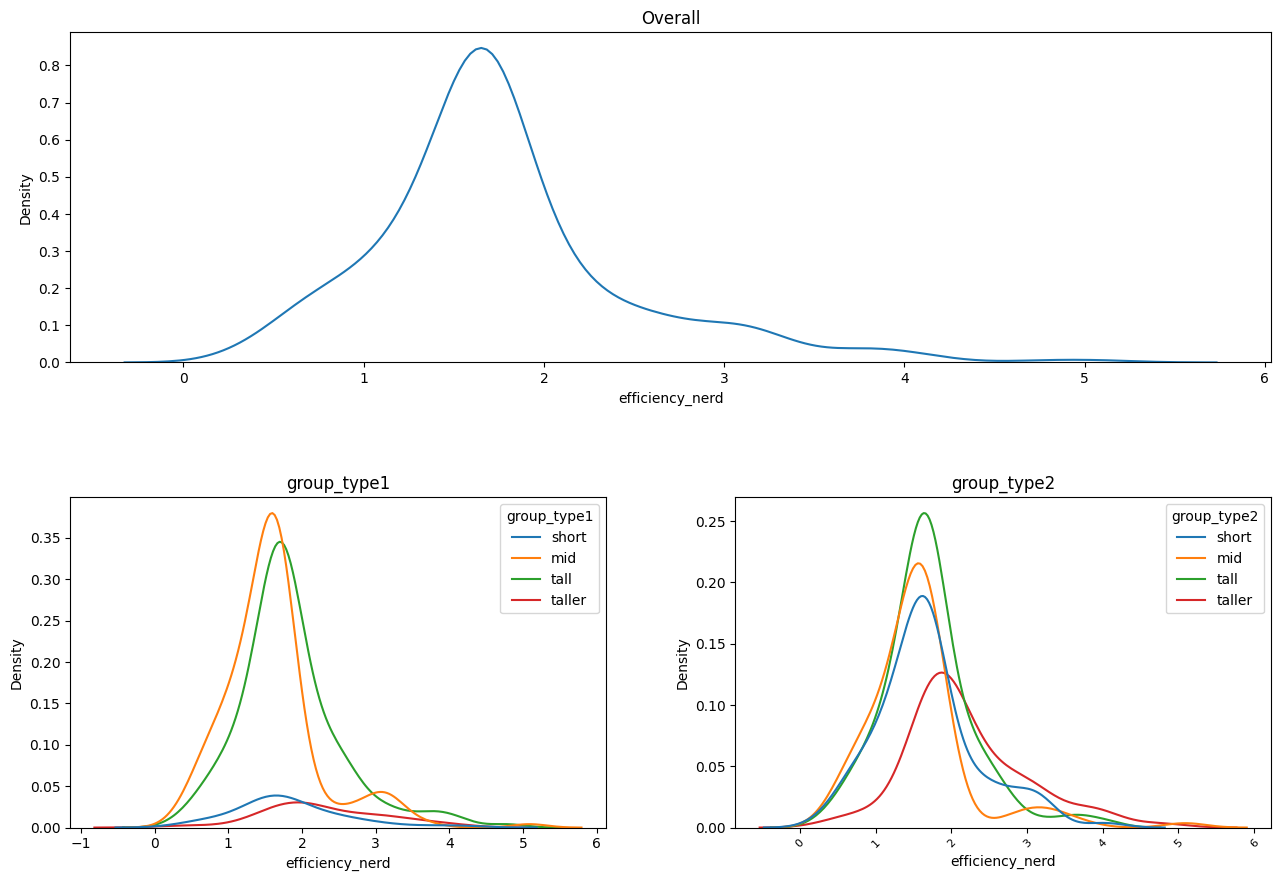

count    408.000000
mean       1.754981
std        0.713122
min        0.316228
25%        1.405261
50%        1.673320
75%        1.936364
max        5.089204
Name: efficiency_nerd, dtype: float64
for over all: 
 ShapiroResult(statistic=0.9148612935872588, pvalue=2.0970003308367783e-14)
for group_type1:
 [ShapiroResult(statistic=0.8743853963704139, pvalue=4.843344646717099e-11), ShapiroResult(statistic=0.9175355602372564, pvalue=1.560927124425696e-08), ShapiroResult(statistic=0.9135427591161789, pvalue=0.031807605347911605), ShapiroResult(statistic=0.9487861219399223, pvalue=0.2549927508040599)]
for group_type2:
 [ShapiroResult(statistic=0.8028385888370084, pvalue=2.2974998643454924e-10), ShapiroResult(statistic=0.9291282313488148, pvalue=0.00026384327688993827), ShapiroResult(statistic=0.9329160550481321, pvalue=1.0796181270873642e-05), ShapiroResult(statistic=0.9402854602661522, pvalue=0.00017196449089453553)]


In [11]:
new_df= anova_df.copy(deep=True)

new_df["efficiency_nerd"]= np.sqrt(new_df["efficiency_nerd"])

fig= plt.figure(figsize=(14,10))

plt.subplot(211).title.set_text('Overall')
sns.kdeplot(data= new_df, x= "efficiency_nerd")

plt.subplot(223).title.set_text('group_type1')
sns.kdeplot(data= new_df, x= "efficiency_nerd", hue= "group_type1")
plt.subplot(224).title.set_text('group_type2')
sns.kdeplot(data= new_df, x= "efficiency_nerd", hue= "group_type2")

fig.tight_layout(pad=5.0)
plt.xticks(rotation=45,fontsize=8)
plt.show()


print(new_df["efficiency_nerd"].describe())
print("for over all: \n", shapiro(new_df["efficiency_nerd"]))
print("for group_type1:\n", [shapiro(new_df[new_df["group_type1"]== i]["efficiency_nerd"]) for i in new_df["group_type1"].unique()])
print("for group_type2:\n", [shapiro(new_df[new_df["group_type2"]== i]["efficiency_nerd"]) for i in new_df["group_type2"].unique()])

del(new_df)

<div class="alert alert-block alert-info">
<b>Findings:</b> Seems like log transformation worked, not 
</div>



In [38]:
anova_df["efficiency_nerd"]= np.log(anova_df["efficiency_nerd"])

In [39]:
anova_df.describe().T

,count,mean,std,min,25%,50%,75%,max
height_in_cm,408.0,199.730637,8.032617,173.000000,195.250000,199.500000,206.000000,224.000000
efficiency_nerd,408.0,0.960714,0.839651,-2.302585,0.680324,1.029619,1.321494,3.254243


In [40]:
i,j,k,l= [anova_df[anova_df["group_type1"]== col]["efficiency_nerd"] for col in anova_df["group_type1"].unique()]
f_oneway(i,j,k,l)

F_onewayResult(statistic=8.012509037248979, pvalue=3.3675989781329344e-05)

In [41]:
i,j,k,l= [anova_df[anova_df["group_type2"]== col]["efficiency_nerd"] for col in anova_df["group_type2"].unique()]
f_oneway(i,j,k,l)

F_onewayResult(statistic=12.801248697857327, pvalue=5.244428762163534e-08)

<div class="alert alert-block alert-info">
<b>Findings:</b> Since the p-value is less than 0.05 in both case, hence we would reject the null hypothesis. This implies that we have sufficient proof to say that there is a difference in the performance among different height groups.
</div>



<div class="alert alert-block alert-warning">
<b>Warning:</b> Since the data is not normally distributed the ANOVA test is not perfect fit for Hypothesis Testing
</div>

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Option 2. Kruskal-Wallis test
</div>

In [42]:
i,j,k,l= [htest_nerd_df[htest_nerd_df["group_type1"]== col]["efficiency_nerd"] for col in htest_nerd_df["group_type1"].unique()]
kruskal(i,j,k,l)

KruskalResult(statistic=35.16823147584346, pvalue=1.1225139177000187e-07)

In [43]:
i,j,k,l= [htest_nerd_df[htest_nerd_df["group_type2"]== col]["efficiency_nerd"] for col in htest_nerd_df["group_type2"].unique()]
kruskal(i,j,k,l)

KruskalResult(statistic=54.113347139064736, pvalue=1.0613103209038338e-11)

<div class="alert alert-block alert-info">
<b>Findings:</b> Since the p-value is less than 0.05 in both case, hence we would reject the null hypothesis. This implies that we have sufficient proof to say that there is a difference in the performance among different height groups.
</div>